# Data Preprocessing


# **1. Data Cleaning**
►Handling Missing Values

    1.1 Ignore tuples with missing values
    1.2 Fill missing values manually
    1.3 Replace with a global constant
    1.4 Replace with measures of central tendency (mean, median, mode)
    1.5 Replace with the most probable value
►Handling Noisy Data

    2.1 Smoothing by binning
    2.2 Bin means
    2.3 Bin boundaries
    2.4 Smoothing with regression
►Handling Inconsistent Data

    3.1 Structural inconsistency
    3.2 Semantic inconsistency
    3.3 Representational inconsistency
    3.4 Data-level inconsistency


___________
___________

►Handling Missing Values

    1.1 Ignore tuples with missing values
    1.2 Fill missing values manually
    1.3 Replace with a global constant
    1.4 Replace with measures of central tendency (mean, median, mode)
    1.5 Replace with the most probable value

►Handling Noisy Data

    2.1 Smoothing by binning
    2.2 Bin means
    2.3 Bin boundaries
    2.4 Smoothing with regression

►Handling Inconsistent Data

    3.1 Structural inconsistency
    3.2 Semantic inconsistency
    3.3 Representational inconsistency
    3.4 Data-level inconsistency

In [124]:
from typing import Optional, Union, Callable, List, Dict
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

class DataCleaner:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def drop_missing(self) -> pd.DataFrame:
        return self.df.dropna()

    def fill_with_constant(self, value: Union[int, float, str] = 0) -> pd.DataFrame:
        return self.df.fillna(value)

    def fill_with_central_tendency(self, method: str = "mean") -> pd.DataFrame:
        if method == "mean":
            return self.df.fillna(self.df.mean(numeric_only=True))
        elif method == "median":
            return self.df.fillna(self.df.median(numeric_only=True))
        elif method == "mode":
            mode_vals = self.df.mode()
            if not mode_vals.empty:
                return self.df.fillna(mode_vals.iloc[0])
            return self.df
        else:
            raise ValueError("Invalid method: choose 'mean', 'median', or 'mode'")

    def fill_with_most_probable(self, column: str) -> pd.DataFrame:
        if column not in self.df.columns:
            raise KeyError(column)
        mode_series = self.df[column].mode()
        if mode_series.empty:
            return self.df
        mode_value = mode_series.iloc[0]
        self.df[column] = self.df[column].fillna(mode_value)
        return self.df

    def fill_missing_manual(self, mapping: Dict[str, Dict[int, Union[int, float, str]]]) -> pd.DataFrame:
        for col, replacements in mapping.items():
            if col not in self.df.columns:
                continue
            for idx, value in replacements.items():
                if idx in self.df.index and pd.isna(self.df.at[idx, col]):
                    self.df.at[idx, col] = value
        return self.df

    def smooth_by_binning(self, column: str, bins: int = 5, strategy: str = "mean") -> pd.DataFrame:
        if column not in self.df.columns:
            raise KeyError(column)
        col = self.df[column]
        if col.dropna().empty:
            return self.df
        binned, edges = pd.cut(col, bins, retbins=True, duplicates='drop')
        grouped = self.df.groupby(binned, observed=False)[column]
        if strategy == "mean":
            mapping = grouped.transform("mean")
        elif strategy == "boundary":
            def nearest_edge(x):
                m = x.mean()
                return edges[np.abs(edges - m).argmin()]
            mapping = grouped.transform(nearest_edge)
        else:
            raise ValueError("Invalid strategy: choose 'mean' or 'boundary'")
        self.df[column] = mapping
        return self.df

    def smooth_with_regression(self, target: str, features: Optional[List[str]] = None) -> pd.DataFrame:
        if target not in self.df.columns:
            raise KeyError(target)
        if features is None:
            features = [col for col in self.df.columns if col != target]
        df_clean = self.df.dropna(subset=[target] + features)
        if df_clean.empty:
            return self.df
        X, y = df_clean[features], df_clean[target]
        model = LinearRegression().fit(X, y)
        missing_mask = self.df[target].isna()
        features_clean = self.df.loc[missing_mask, features].dropna()
        if not features_clean.empty:
            self.df.loc[features_clean.index, target] = model.predict(features_clean)
        return self.df

    def structural_inconsistency(self) -> pd.DataFrame:
        self.df.columns = [col.strip().lower() for col in self.df.columns]
        return self.df

    def semantic_inconsistency(self, column: str, mapping: Dict) -> pd.DataFrame:
        if column not in self.df.columns:
            raise KeyError(column)
        self.df[column] = self.df[column].replace(mapping)
        return self.df

    def representational_inconsistency(self, column: str, func: Callable) -> pd.DataFrame:
        if column not in self.df.columns:
            raise KeyError(column)
        try:
            self.df[column] = func(self.df[column], errors="coerce")  # type: ignore[arg-type]
        except TypeError:
            self.df[column] = self.df[column].apply(func)
        return self.df

    def data_level_inconsistency(self, column: str, valid_range: tuple) -> pd.DataFrame:
        if column not in self.df.columns:
            raise KeyError(column)
        low, high = valid_range
        mask = (self.df[column] < low) | (self.df[column] > high)
        self.df.loc[mask, column] = np.nan
        return self.df


In [125]:
import numpy as np
import pandas as pd

missing_inputs = {
    "constant_value": 0,
    "central_method": "mean",
    "most_probable_column": "age",
    "manual_mapping": {
        "city": {2: "Tehran"},
        "age": {0: 25, 3: 30}
    }
}

noisy_inputs = {
    "binning_column": "income",
    "bins": 5,
    "strategy": "mean",
    "regression_target": "salary",
    "regression_features": ["age", "experience"]
}

inconsistent_inputs = {
    "semantic_column": "gender",
    "semantic_mapping": {"M": "Male", "F": "Female"},
    "representational_column": "date",
    "representational_func": pd.to_datetime,
    "data_level_column": "age",
    "valid_range": (0, 100)
}

df = pd.DataFrame({
    "age": [25, np.nan, 40, None, 200],
    "income": [3000, 5000, np.nan, 7000, 9000],
    "salary": [4000, None, 6000, 8000, None],
    "experience": [1, 3, 5, 7, 9],
    "gender": ["M", "F", "M", None, "F"],
    "city": ["Tehran", None, None, "Shiraz", "Tabriz"],
    "date": ["2020-01-01", "2021/02/01", None, "2022-03-15", "2023-04-20"]
})

# اینجا دیگه نیازی به import نیست، چون DataCleaner بالا تعریف شده
cleaner = DataCleaner(df)
print("Original DataFrame:\\n", df, "\\n")

print("Drop Missing:\\n", cleaner.drop_missing(), "\\n")

cleaner = DataCleaner(df)
print("Fill with Constant:\\n", cleaner.fill_with_constant(missing_inputs["constant_value"]), "\\n")

cleaner = DataCleaner(df)
print("Fill with Central Tendency:\\n", cleaner.fill_with_central_tendency(missing_inputs["central_method"]), "\\n")

cleaner = DataCleaner(df)
print("Fill with Most Probable:\\n", cleaner.fill_with_most_probable(missing_inputs["most_probable_column"]), "\\n")

cleaner = DataCleaner(df)
print("Fill Missing Manual:\\n", cleaner.fill_missing_manual(missing_inputs["manual_mapping"]), "\\n")

cleaner = DataCleaner(df)
print("Smooth by Binning (Mean):\\n", cleaner.smooth_by_binning(noisy_inputs["binning_column"], noisy_inputs["bins"], noisy_inputs["strategy"]), "\\n")

cleaner = DataCleaner(df)
print("Smooth with Regression:\\n", cleaner.smooth_with_regression(noisy_inputs["regression_target"], noisy_inputs["regression_features"]), "\\n")

cleaner = DataCleaner(df)
print("Structural Inconsistency:\\n", cleaner.structural_inconsistency(), "\\n")

cleaner = DataCleaner(df)
print("Semantic Inconsistency:\\n", cleaner.semantic_inconsistency(inconsistent_inputs["semantic_column"], inconsistent_inputs["semantic_mapping"]), "\\n")

cleaner = DataCleaner(df)
print("Representational Inconsistency:\\n", cleaner.representational_inconsistency(inconsistent_inputs["representational_column"], inconsistent_inputs["representational_func"]), "\\n")

cleaner = DataCleaner(df)
print("Data Level Inconsistency:\\n", cleaner.data_level_inconsistency(inconsistent_inputs["data_level_column"], inconsistent_inputs["valid_range"]), "\\n")


Original DataFrame:\n      age  income  salary  experience gender    city        date
0   25.0  3000.0  4000.0           1      M  Tehran  2020-01-01
1    NaN  5000.0     NaN           3      F    None  2021/02/01
2   40.0     NaN  6000.0           5      M    None        None
3    NaN  7000.0  8000.0           7   None  Shiraz  2022-03-15
4  200.0  9000.0     NaN           9      F  Tabriz  2023-04-20 \n
Drop Missing:\n     age  income  salary  experience gender    city        date
0  25.0  3000.0  4000.0           1      M  Tehran  2020-01-01 \n
Fill with Constant:\n      age  income  salary  experience gender    city        date
0   25.0  3000.0  4000.0           1      M  Tehran  2020-01-01
1    0.0  5000.0     0.0           3      F       0  2021/02/01
2   40.0     0.0  6000.0           5      M       0           0
3    0.0  7000.0  8000.0           7      0  Shiraz  2022-03-15
4  200.0  9000.0     0.0           9      F  Tabriz  2023-04-20 \n
Fill with Central Tendency:\n        

# **2 Supervised Learning Algorithms**
►Distance Measures

    1.1 Minkowski Distance
    1.2 Euclidean Distance
    1.3 Manhattan Distance
    1.4 Chebyshev Distance
►Classification Algorithms

    2.1 K-Nearest Neighbors (KNN)
►Probabilistic

    3.1 Naïve Bayes (simple)
    3.2 Naïve Bayes Classifier
►Linear and Support Vector Models

    4.1 Perceptron (Single-layer with Bias)
    4.2 Perceptron (Single-layer without Bias)
    4.3 Support Vector Machine (SVM)
 ►Decision Trees

    5.1 Basic Decision Tree
    5.2 Pre-pruning using Entropy
    5.3 Post-pruning using Information Gain
►Regression Algorithms

    6.1 Univariate Linear Regression
    6.2 Multivariate Linear Regression
    6.3 Univariate Polynomial Regression
    6.4 Multivariate Polynomial Regression
►Optimization and Regularization

    7.1 Gradient Descent Algorithm
    7.2 Ridge Regularization
    7.3 Lasso Regularization

___________
___________

►Distance Measures

    1.1 Minkowski Distance
    1.2 Euclidean Distance
    1.3 Manhattan Distance
    1.4 Chebyshev Distance

In [107]:
import numpy as np
from typing import Union, Sequence

class DistanceMetrics:

    @staticmethod
    def minkowski(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray],
                  p: int = 2) -> float:
        x_arr, y_arr = np.array(x), np.array(y)
        if x_arr.shape != y_arr.shape:
            raise ValueError("Vectors must have the same dimensions")
        return np.sum(np.abs(x_arr - y_arr) ** p) ** (1 / p)

    @staticmethod
    def euclidean(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        return DistanceMetrics.minkowski(x, y, p=2)

    @staticmethod
    def manhattan(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        return DistanceMetrics.minkowski(x, y, p=1)

    @staticmethod
    def chebyshev(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        x_arr, y_arr = np.array(x), np.array(y)
        if x_arr.shape != y_arr.shape:
            raise ValueError("Vectors must have the same dimensions")
        return np.max(np.abs(x_arr - y_arr))

def test_minkowski_distance():
    x, y = [0, 0], [3, 4]
    assert round(DistanceMetrics.minkowski(x, y, p=2), 5) == 5.0
    assert round(DistanceMetrics.minkowski(x, y, p=1), 5) == 7.0
    assert round(DistanceMetrics.minkowski(x, y, p=3), 5) == round((3**3 + 4**3) ** (1/3), 5)

def test_euclidean_distance():
    x, y = [1, 2], [4, 6]
    assert round(DistanceMetrics.euclidean(x, y), 5) == 5.0

def test_manhattan_distance():
    x, y = [1, 2, 3], [4, 6, 3]
    assert DistanceMetrics.manhattan(x, y) == 7

def test_chebyshev_distance():
    x, y = [1, 2, 3], [4, 6, 8]
    assert DistanceMetrics.chebyshev(x, y) == 5

def test_invalid_dimensions():
    x, y = [1, 2], [1, 2, 3]
    try:
        DistanceMetrics.euclidean(x, y)
        assert False
    except ValueError:
        assert True

test_minkowski_distance()
test_euclidean_distance()
test_manhattan_distance()
test_chebyshev_distance()
test_invalid_dimensions()
print("...")

...


In [108]:
x = [2, 5, 9]
y = [7, 1, 3]

print("Minkowski (p=2):", DistanceMetrics.minkowski(x, y, p=2))
print("Minkowski (p=3):", DistanceMetrics.minkowski(x, y, p=3))
print("Euclidean:", DistanceMetrics.euclidean(x, y))
print("Manhattan:", DistanceMetrics.manhattan(x, y))
print("Chebyshev:", DistanceMetrics.chebyshev(x, y))

Minkowski (p=2): 8.774964387392123
Minkowski (p=3): 7.398636222991409
Euclidean: 8.774964387392123
Manhattan: 15.0
Chebyshev: 6


►Classification Algorithms

    2.1 K-Nearest Neighbors (KNN)


In [109]:
from typing import Union, Sequence
import numpy as np
import pytest
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

class DistanceMetrics:
    @staticmethod
    def minkowski(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray],
                  p: int = 2) -> float:
        x_arr, y_arr = np.array(x), np.array(y)
        if x_arr.shape != y_arr.shape:
            raise ValueError("Vectors must have the same dimensions")
        return np.sum(np.abs(x_arr - y_arr) ** p) ** (1 / p)

    @staticmethod
    def euclidean(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        return DistanceMetrics.minkowski(x, y, p=2)

    @staticmethod
    def manhattan(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        return DistanceMetrics.minkowski(x, y, p=1)

    @staticmethod
    def chebyshev(x: Union[Sequence[float], np.ndarray],
                  y: Union[Sequence[float], np.ndarray]) -> float:
        x_arr, y_arr = np.array(x), np.array(y)
        if x_arr.shape != y_arr.shape:
            raise ValueError("Vectors must have the same dimensions")
        return np.max(np.abs(x_arr - y_arr))

class KNNClassifier:
    def __init__(self, k: int = 3, distance_metric: str = "euclidean"):
        if k <= 0:
            raise ValueError("k must be a positive integer")
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None

    def fit(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> None:
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        if self.X_train.shape[0] != self.y_train.shape[0]:
            raise ValueError("Number of samples in X and y must match")

    def _compute_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        if self.distance_metric == "euclidean":
            return DistanceMetrics.euclidean(x1, x2)
        elif self.distance_metric == "manhattan":
            return DistanceMetrics.manhattan(x1, x2)
        elif self.distance_metric == "chebyshev":
            return DistanceMetrics.chebyshev(x1, x2)
        elif self.distance_metric == "minkowski":
            return DistanceMetrics.minkowski(x1, x2, p=3)
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

    def predict(self, X: Union[np.ndarray, list]) -> np.ndarray:
        if self.X_train is None or self.y_train is None:
            raise ValueError("Model must be fitted before prediction")

        X = np.array(X)
        predictions = []
        for x in X:
            distances = [self._compute_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            values, counts = np.unique(k_nearest_labels, return_counts=True)
            predictions.append(values[np.argmax(counts)])
        return np.array(predictions)

    def score(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> float:
        predictions = self.predict(X)
        y = np.array(y)
        return np.mean(predictions == y)

def test_knn_fit_and_predict_euclidean():
    X_train = [[0, 0], [1, 1], [2, 2], [3, 3]]
    y_train = [0, 0, 1, 1]
    knn = KNNClassifier(k=3, distance_metric="euclidean")
    knn.fit(X_train, y_train)
    X_test = [[1.5, 1.5], [0.2, 0.1], [2.8, 3.0]]
    predictions = knn.predict(X_test)
    assert list(predictions) == [0, 0, 1]

def test_knn_score():
    X_train = [[0, 0], [1, 1], [2, 2], [3, 3]]
    y_train = [0, 0, 1, 1]
    knn = KNNClassifier(k=3)
    knn.fit(X_train, y_train)
    X_test = [[0.9, 1.0], [2.5, 2.4]]
    y_test = [0, 1]
    score = knn.score(X_test, y_test)
    assert 0.0 <= score <= 1.0
    assert score == 1.0

def test_knn_with_manhattan():
    X_train = [[0, 0], [0, 1], [1, 0], [1, 1]]
    y_train = [0, 1, 1, 0]
    knn = KNNClassifier(k=1, distance_metric="manhattan")
    knn.fit(X_train, y_train)
    assert knn.predict([[0.9, 0.1]])[0] in [0, 1]

def test_knn_with_chebyshev():
    X_train = [[0, 0], [3, 3]]
    y_train = [0, 1]
    knn = KNNClassifier(k=1, distance_metric="chebyshev")
    knn.fit(X_train, y_train)
    assert knn.predict([[2, 2]])[0] == 1

def test_knn_invalid_k():
    with pytest.raises(ValueError):
        KNNClassifier(k=0)

def test_knn_mismatched_dimensions():
    X_train = [[0, 0], [1, 1]]
    y_train = [0]
    knn = KNNClassifier(k=1)
    with pytest.raises(ValueError):
        knn.fit(X_train, y_train)

def test_knn_predict_before_fit():
    knn = KNNClassifier(k=1)
    with pytest.raises(ValueError):
        knn.predict([[0, 0]])

if __name__ == "__main__":
    iris = load_iris()
    X, y = iris.data, iris.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    knn = KNNClassifier(k=5, distance_metric="euclidean")
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    print("Sample predictions:", predictions[:10])
    print("Real labels:", y_test[:10])
    accuracy = knn.score(X_test, y_test)
    print("Accuracy on Iris dataset:", accuracy)

Sample predictions: [1 0 2 1 1 0 1 2 1 1]
Real labels: [1 0 2 1 1 0 1 2 1 1]
Accuracy on Iris dataset: 1.0


►Probabilistic

    3.1 Naïve Bayes (simple)
    3.2 Naïve Bayes Classifier

In [110]:
from typing import Union
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

class NaiveBayesSimple:

    def __init__(self):
        self.class_priors = None
        self.feature_probs = None
        self.classes = None

    def fit(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> None:
        X = np.array(X)
        y = np.array(y)
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.class_priors = class_counts / len(y)

        n_samples, n_features = X.shape
        self.feature_probs = {}

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.feature_probs[cls] = []
            for f in range(n_features):
                values, counts = np.unique(X_cls[:, f], return_counts=True)
                probs = {v: (c + 1) / (len(X_cls) + len(values)) for v, c in zip(values, counts)}
                self.feature_probs[cls].append(probs)

    def predict(self, X: Union[np.ndarray, list]) -> np.ndarray:
        X = np.array(X)
        predictions = []
        for x in X:
            class_probs = []
            for idx, cls in enumerate(self.classes):
                prior = self.class_priors[idx]
                likelihood = 1
                for f, val in enumerate(x):
                    likelihood *= self.feature_probs[cls][f].get(val, 1e-6)
                class_probs.append(prior * likelihood)
            predictions.append(self.classes[np.argmax(class_probs)])
        return np.array(predictions)

    def score(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> float:
        predictions = self.predict(X)
        return np.mean(predictions == np.array(y))


class NaiveBayesClassifier:

    def __init__(self):
        self.class_priors = None
        self.classes = None
        self.mean = {}
        self.var = {}

    def fit(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> None:
        X = np.array(X)
        y = np.array(y)
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.class_priors = class_counts / len(y)

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.mean[cls] = X_cls.mean(axis=0)
            self.var[cls] = X_cls.var(axis=0) + 1e-6

    def _gaussian_prob(self, x, mean, var):
        coeff = 1.0 / np.sqrt(2.0 * np.pi * var)
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return coeff * exponent

    def predict(self, X: Union[np.ndarray, list]) -> np.ndarray:
        X = np.array(X)
        predictions = []
        for x in X:
            class_probs = []
            for idx, cls in enumerate(self.classes):
                prior = self.class_priors[idx]
                likelihoods = self._gaussian_prob(x, self.mean[cls], self.var[cls])
                likelihood = np.prod(likelihoods)
                class_probs.append(prior * likelihood)
            predictions.append(self.classes[np.argmax(class_probs)])
        return np.array(predictions)

    def predict_proba(self, X: Union[np.ndarray, list]) -> np.ndarray:
        X = np.array(X)
        probas = []
        for x in X:
            class_probs = []
            for idx, cls in enumerate(self.classes):
                prior = self.class_priors[idx]
                likelihoods = self._gaussian_prob(x, self.mean[cls], self.var[cls])
                likelihood = np.prod(likelihoods)
                class_probs.append(prior * likelihood)
            class_probs = np.array(class_probs)
            probas.append(class_probs / np.sum(class_probs))
        return np.array(probas)

    def score(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list]) -> float:
        predictions = self.predict(X)
        return np.mean(predictions == np.array(y))

if __name__ == "__main__":
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model = NaiveBayesClassifier()
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print("NaiveBayesClassifier Accuracy on Breast Cancer dataset:", acc)

NaiveBayesClassifier Accuracy on Breast Cancer dataset: 0.9649122807017544


►Linear and Support Vector Models

    4.1 Perceptron (Single-layer with Bias)
    4.2 Perceptron (Single-layer without Bias)
    4.3 Support Vector Machine (SVM)

--- Perceptron With Bias ---
Accuracy: 0.775
Confusion Matrix:
 [[15  8]
 [ 1 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.65      0.77        23
           1       0.67      0.94      0.78        17

    accuracy                           0.78        40
   macro avg       0.80      0.80      0.77        40
weighted avg       0.82      0.78      0.77        40

--- Perceptron Without Bias ---
Accuracy: 0.85
Confusion Matrix:
 [[18  5]
 [ 1 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       0.76      0.94      0.84        17

    accuracy                           0.85        40
   macro avg       0.85      0.86      0.85        40
weighted avg       0.87      0.85      0.85        40



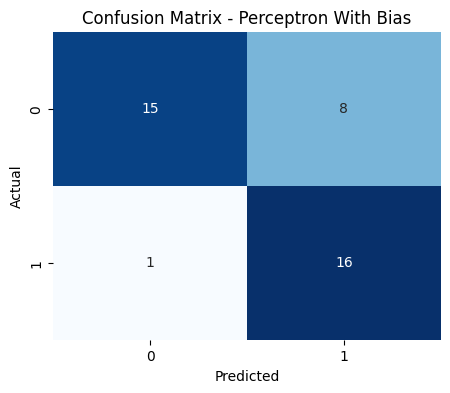

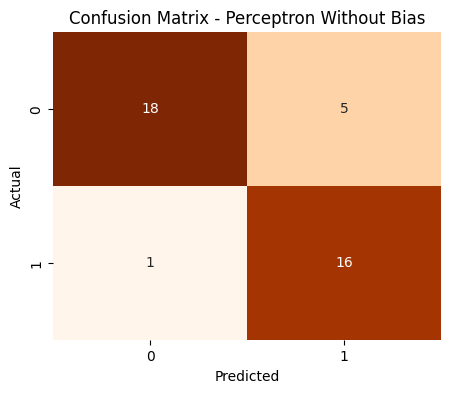

In [111]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class PerceptronWithBias:
    def __init__(self, lr: float = 0.01, epochs: int = 100):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        y_ = np.where(y <= 0, -1, 1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_pred = np.where(linear_output >= 0, 1, -1)
                update = self.lr * (y_[idx] - y_pred)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X: np.ndarray) -> np.ndarray:
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, 0)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return np.mean(preds == y)

class PerceptronWithoutBias:
    def __init__(self, lr: float = 0.01, epochs: int = 100):
        self.lr = lr
        self.epochs = epochs
        self.weights = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        y_ = np.where(y <= 0, -1, 1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights)
                y_pred = np.where(linear_output >= 0, 1, -1)
                update = self.lr * (y_[idx] - y_pred)
                self.weights += update * x_i

    def predict(self, X: np.ndarray) -> np.ndarray:
        linear_output = np.dot(X, self.weights)
        return np.where(linear_output >= 0, 1, 0)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return np.mean(preds == y)

if __name__ == "__main__":
    X, y = make_classification(
        n_samples=200, n_features=2, n_informative=2, n_redundant=0,
        n_clusters_per_class=1, random_state=42)

    y = np.where(y == 0, 0, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("--- Perceptron With Bias ---")
    model_bias = PerceptronWithBias(lr=0.01, epochs=100)
    model_bias.fit(X_train, y_train)
    preds_bias = model_bias.predict(X_test)
    print("Accuracy:", model_bias.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds_bias))
    print("Classification Report:\n", classification_report(y_test, preds_bias))
    print("--- Perceptron Without Bias ---")
    model_no_bias = PerceptronWithoutBias(lr=0.01, epochs=100)
    model_no_bias.fit(X_train, y_train)
    preds_no_bias = model_no_bias.predict(X_test)
    print("Accuracy:", model_no_bias.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds_no_bias))
    print("Classification Report:\n", classification_report(y_test, preds_no_bias))
    cm_bias = confusion_matrix(y_test, preds_bias)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_bias, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix - Perceptron With Bias")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    cm_no_bias = confusion_matrix(y_test, preds_no_bias)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_no_bias, annot=True, fmt="d", cmap="Oranges", cbar=False)
    plt.title("Confusion Matrix - Perceptron Without Bias")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

To understand the code, it is necessary to study the theory of hinge loss.

--- Support Vector Machine ---
Accuracy: 0.956140350877193
Confusion Matrix:
 [[38  5]
 [ 0 71]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        43
           1       0.93      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



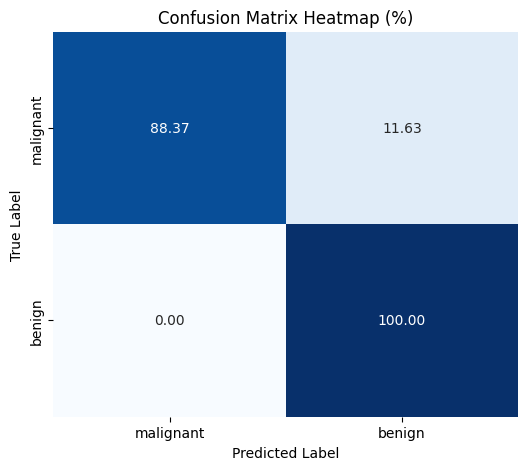

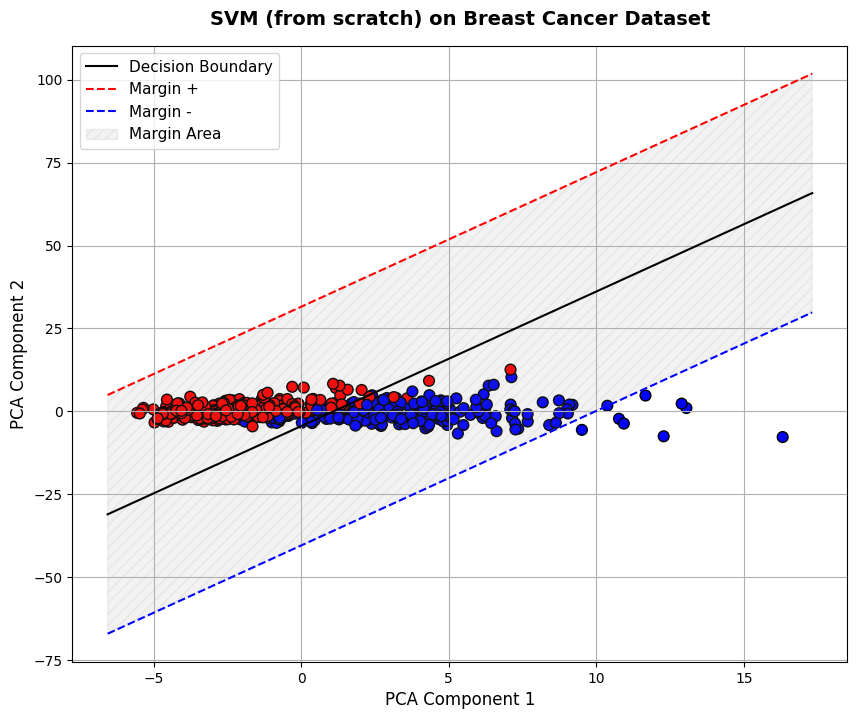

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class SVM:
    def __init__(self, lr: float = 0.001, epochs: int = 1000, C: float = 1.0):
        self.lr = lr
        self.epochs = epochs
        self.C = C
        self.w = None
        self.b = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        y_ = np.where(y <= 0, -1, 1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b)
                if condition >= 1:
                    self.w -= self.lr * (2 * self.w)
                else:
                    self.w -= self.lr * (2 * self.w - self.C * y_[idx] * x_i)
                    self.b -= self.lr * (-self.C * y_[idx])

    def predict(self, X: np.ndarray) -> np.ndarray:
        linear_output = np.dot(X, self.w) + self.b
        return np.where(linear_output >= 0, 1, 0)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return np.mean(preds == y)


if __name__ == "__main__":
    data = load_breast_cancer()
    X, y = data.data, data.target
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(
        X_2d, y, test_size=0.2, random_state=42)
    print("--- Support Vector Machine ---")
    model = SVM(lr=0.001, epochs=2000, C=1.0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("Accuracy:", model.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=data.target_names, yticklabels=data.target_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap (%)")
    plt.show()
    w, b = model.w, model.b
    norm = np.linalg.norm(w)
    xx = np.linspace(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, 500)
    yy = -(w[0] * xx + b) / w[1]
    margin = 1 / norm
    yy_plus = -(w[0] * xx + b - margin) / w[1]
    yy_minus = -(w[0] * xx + b + margin) / w[1]
    plt.figure(figsize=(10, 8))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=plt.cm.bwr, s=60, edgecolors='k')
    plt.plot(xx, yy, 'k-', label="Decision Boundary")
    plt.plot(xx, yy_plus, 'r--', label="Margin +")
    plt.plot(xx, yy_minus, 'b--', label="Margin -")
    plt.fill_between(xx, yy_minus, yy_plus, color='gray', alpha=0.1, hatch='///', label="Margin Area")
    plt.xlabel("PCA Component 1", fontsize=12)
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.title("SVM (from scratch) on Breast Cancer Dataset", fontsize=14, fontweight='bold', pad=15)
    plt.legend(fontsize=11)
    plt.grid(True)
    plt.show()

 ►Decision Trees

    5.1 Basic Decision Tree
    5.2 Pre-pruning using Entropy
    5.3 Post-pruning using Information Gain

In [113]:
from __future__ import annotations
from typing import Optional, Any
import numpy as np
import pandas as pd


class Node:
    def __init__(
        self,
        feature: Optional[int] = None,
        threshold: Optional[Any] = None,
        children: Optional[dict] = None,
        *,
        value: Optional[Any] = None
    ):
        self.feature = feature
        self.threshold = threshold
        self.children = children or {}
        self.value = value

    def is_leaf(self) -> bool:
        return self.value is not None

class DecisionTree:
    def __init__(
        self,
        criterion: str = "entropy",
        max_depth: Optional[int] = None,
        min_samples_leaf: int = 1,
        min_information_gain: float = 1e-6,
    ):
        self.criterion = criterion
        self.max_depth = max_depth if max_depth is not None else np.inf
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.tree_: Optional[Node] = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X, y = np.array(X), np.array(y)
        attributes = list(range(X.shape[1]))
        self.tree_ = self._build_tree(X, y, attributes, depth=0)
        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        X = np.array(X)
        return np.array([self._predict_one(row, self.tree_) for row in X])

    def _entropy(self, y: np.ndarray) -> float:
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-9))

    def _information_gain(self, y: np.ndarray, splits: list[np.ndarray]) -> float:
        parent_entropy = self._entropy(y)
        n = len(y)
        child_entropy = 0.0
        for idx in splits:
            if len(idx) == 0:
                continue
            child_entropy += (len(idx) / n) * self._entropy(y[idx])
        return parent_entropy - child_entropy

    def _best_split(self, X: np.ndarray, y: np.ndarray, attributes: list[int]):
        best_gain = 0.0
        best_feature, best_threshold = None, None

        for feature in attributes:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = np.where(X[:, feature] <= threshold)[0]
                right_idx = np.where(X[:, feature] > threshold)[0]
                gain = self._information_gain(y, [left_idx, right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold, best_gain

    def _build_tree(self, X: np.ndarray, y: np.ndarray, attributes: list[int], depth: int) -> Node:
        if len(np.unique(y)) == 1:
            return Node(value=y[0])

        if len(attributes) == 0 or depth >= self.max_depth or len(y) < self.min_samples_leaf:
            return Node(value=self._majority_class(y))

        feature, threshold, gain = self._best_split(X, y, attributes)

        if feature is None or gain < self.min_information_gain:
            return Node(value=self._majority_class(y))

        node = Node(feature=feature, threshold=threshold)
        left_idx = np.where(X[:, feature] <= threshold)[0]
        right_idx = np.where(X[:, feature] > threshold)[0]

        if len(left_idx) == 0 or len(right_idx) == 0:
            return Node(value=self._majority_class(y))

        node.children['left'] = self._build_tree(X[left_idx], y[left_idx], attributes, depth + 1)
        node.children['right'] = self._build_tree(X[right_idx], y[right_idx], attributes, depth + 1)

        return node

    def _predict_one(self, row: np.ndarray, node: Node):
        if node.is_leaf():
            return node.value
        if row[node.feature] <= node.threshold:
            return self._predict_one(row, node.children['left'])
        else:
            return self._predict_one(row, node.children['right'])

    def _majority_class(self, y: np.ndarray):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def prune_post(self):
        if self.tree_:
            self.tree_ = self._prune_node(self.tree_)

    def _prune_node(self, node: Node):
        if node.is_leaf():
            return node
        for key in list(node.children.keys()):
            node.children[key] = self._prune_node(node.children[key])

        if all(child.is_leaf() for child in node.children.values()):
            left, right = node.children['left'], node.children['right']
            if left.value == right.value:
                return Node(value=left.value)
        return node


if __name__ == "__main__":
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import seaborn as sns
    titanic = sns.load_dataset("titanic")
    features = ["pclass", "age", "sibsp", "parch", "fare"]
    titanic = titanic[features + ["survived"]].dropna()
    X = titanic[features]
    y = titanic["survived"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    tree_base = DecisionTree(max_depth=6, min_information_gain=0.0)
    tree_base.fit(X_train, y_train)
    y_pred_base = tree_base.predict(X_test)
    print("Base Accuracy:", accuracy_score(y_test, y_pred_base))
    tree_pre = DecisionTree(max_depth=6, min_information_gain=0.05)
    tree_pre.fit(X_train, y_train)
    y_pred_pre = tree_pre.predict(X_test)
    print("Pre-pruning Accuracy:", accuracy_score(y_test, y_pred_pre))
    tree_post = DecisionTree(max_depth=6, min_information_gain=0.0)
    tree_post.fit(X_train, y_train)
    tree_post.prune_post()
    y_pred_post = tree_post.predict(X_test)
    print("Post-pruning Accuracy:", accuracy_score(y_test, y_pred_post))
    tree_both = DecisionTree(max_depth=6, min_information_gain=0.05)
    tree_both.fit(X_train, y_train)
    tree_both.prune_post()
    y_pred_both = tree_both.predict(X_test)
    print("Pre+Post Accuracy:", accuracy_score(y_test, y_pred_both))

Base Accuracy: 0.6837209302325581
Pre-pruning Accuracy: 0.6930232558139535
Post-pruning Accuracy: 0.6837209302325581
Pre+Post Accuracy: 0.6930232558139535


►Regression Algorithms


    6.1 Univariate Linear Regression
    6.2 Multivariate Linear Regression
    6.3 Univariate Polynomial Regression
    6.4 Multivariate Polynomial Regression

In [114]:
from typing import Optional, Union
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


class RegressionModels:
    def __init__(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        self.X = X
        self.y = y
        self.model: Optional[object] = None
        self.poly: Optional[PolynomialFeatures] = None

    def fit_univariate_linear(self, x: np.ndarray, y: np.ndarray) -> None:
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        self.model = LinearRegression()
        self.model.fit(x, y)

    def fit_multivariate_linear(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]) -> None:
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.model = LinearRegression()
        self.model.fit(X, y)

    def fit_univariate_polynomial(self, x: np.ndarray, y: np.ndarray, degree: int = 2) -> None:
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        self.poly = PolynomialFeatures(degree=degree)
        X_poly = self.poly.fit_transform(x)
        self.model = LinearRegression()
        self.model.fit(X_poly, y)

    def fit_multivariate_polynomial(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray], degree: int = 2) -> None:
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.poly = PolynomialFeatures(degree=degree)
        X_poly = self.poly.fit_transform(X)
        self.model = LinearRegression()
        self.model.fit(X_poly, y)

    def predict(self, X_new: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.model is None:
            raise ValueError("No model has been trained yet.")
        if isinstance(X_new, pd.DataFrame):
            X_new = X_new.values
        if self.poly is not None:
            X_new = self.poly.transform(X_new)
        return self.model.predict(X_new)

    def evaluate(self, X_test: Union[pd.DataFrame, np.ndarray], y_test: Union[pd.Series, np.ndarray]) -> dict:
        if self.model is None:
            raise ValueError("No model has been trained yet.")
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values
        if self.poly is not None:
            X_test = self.poly.transform(X_test)
        y_pred = self.model.predict(X_test)
        return {
            "mse": mean_squared_error(y_test, y_pred),
            "r2": r2_score(y_test, y_pred)
        }

import pytest


@pytest.fixture
def sample_data():
    X = np.array([[1], [2], [3], [4], [5]])
    y = np.array([2, 4, 6, 8, 10])
    return X, y


def test_fit_univariate_linear(sample_data):
    X, y = sample_data
    model = RegressionModels(X, y)
    model.fit_univariate_linear(X, y)
    preds = model.predict(X)
    assert np.allclose(preds, y, atol=1e-6)


def test_fit_multivariate_linear():
    X = pd.DataFrame({"x1": [1, 2, 3, 4, 5], "x2": [2, 4, 6, 8, 10]})
    y = pd.Series([4, 8, 12, 16, 20])
    model = RegressionModels(X, y)
    model.fit_multivariate_linear(X, y)
    preds = model.predict(X)
    assert np.allclose(preds, y, atol=1e-6)


def test_fit_univariate_polynomial(sample_data):
    X, y = sample_data
    y_poly = np.array([1, 4, 9, 16, 25])
    model = RegressionModels(X, y_poly)
    model.fit_univariate_polynomial(X, y_poly, degree=2)
    preds = model.predict(X)
    assert np.allclose(preds, y_poly, atol=1e-6)


def test_fit_multivariate_polynomial():
    X = pd.DataFrame({"x1": [1, 2, 3], "x2": [2, 3, 4]})
    y = pd.Series([9, 25, 49])
    model = RegressionModels(X, y)
    model.fit_multivariate_polynomial(X, y, degree=2)
    preds = model.predict(X)
    assert preds.shape == y.shape
    assert np.allclose(preds, y, atol=1e-6)


def test_evaluate_method(sample_data):
    X, y = sample_data
    model = RegressionModels(X, y)
    model.fit_univariate_linear(X, y)
    metrics = model.evaluate(X, y)
    assert "mse" in metrics and "r2" in metrics
    assert metrics["mse"] < 1e-6
    assert abs(metrics["r2"] - 1.0) < 1e-6

►Optimization and Regularization

    7.1 Gradient Descent Algorithm
    7.2 Ridge Regularization
    7.3 Lasso Regularization

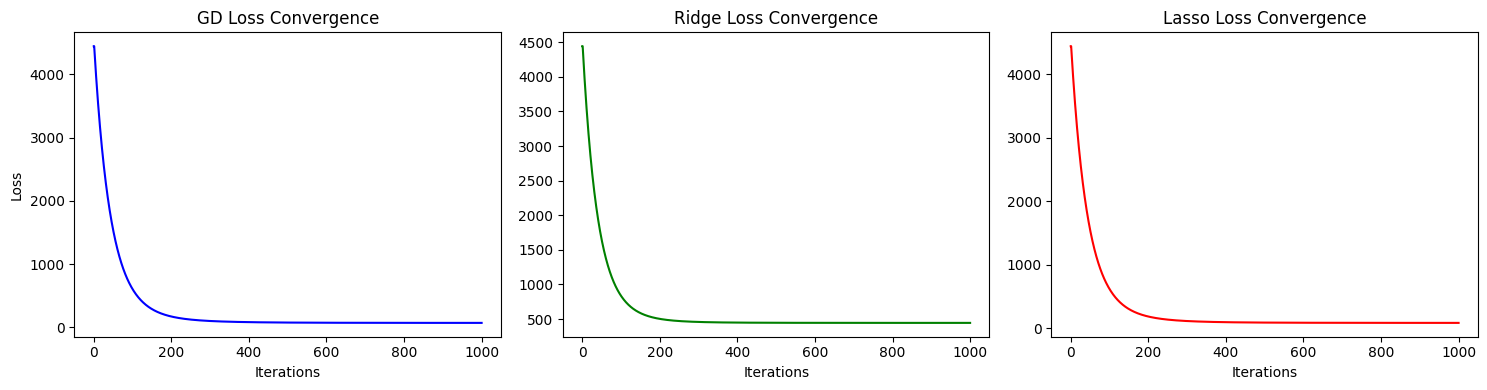

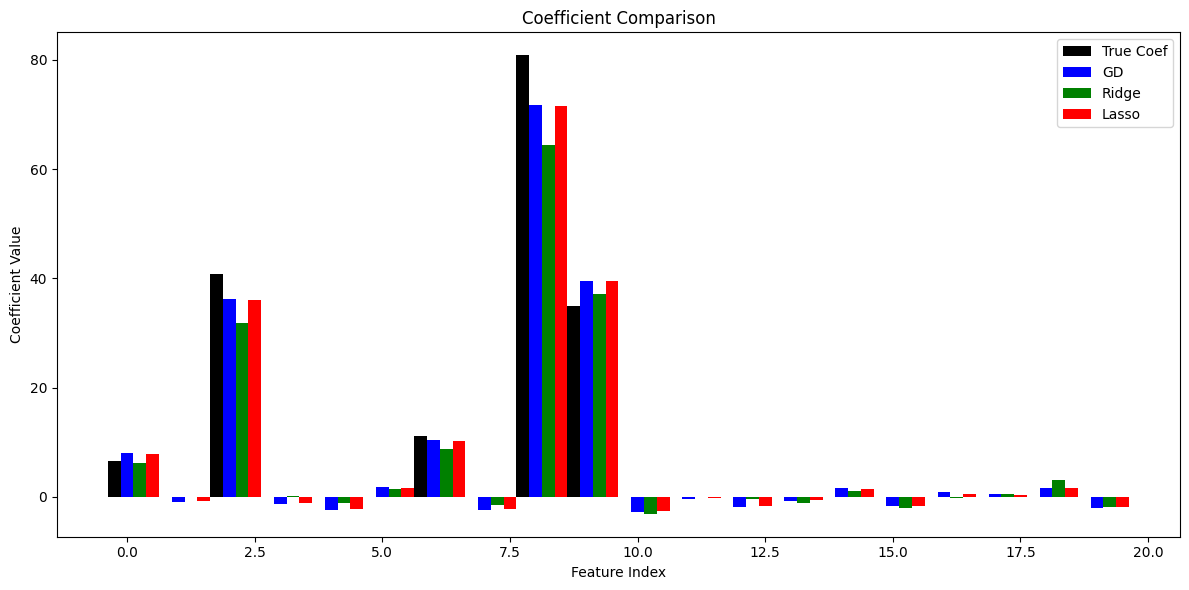

In [115]:
from typing import Optional, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler


class GradientDescentRegressor:
    def __init__(
        self,
        learning_rate: float = 0.01,
        max_iter: int = 1000,
        tolerance: float = 1e-6,
        regularization: Optional[str] = None,
        alpha: float = 0.0,
    ) -> None:
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.regularization = regularization
        self.alpha = alpha
        self.weights: Optional[np.ndarray] = None
        self.bias: float = 0.0
        self.loss_history: List[float] = []

    def _compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        n_samples = len(y)
        y_pred = self.predict(X)
        error = y_pred - y
        loss = (1 / (2 * n_samples)) * np.sum(error**2)
        if self.regularization == "ridge":
            loss += (self.alpha / (2 * n_samples)) * np.sum(self.weights**2)
        elif self.regularization == "lasso":
            loss += (self.alpha / (2 * n_samples)) * np.sum(np.abs(self.weights))
        return loss

    def fit(self, X: np.ndarray, y: np.ndarray) -> "GradientDescentRegressor":
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        self.loss_history = [self._compute_loss(X, y)]
        for _ in range(self.max_iter):
            y_pred = self.predict(X)
            error = y_pred - y
            dw = (1 / n_samples) * (X.T @ error)
            db = (1 / n_samples) * np.sum(error)
            if self.regularization == "ridge":
                dw += (self.alpha / n_samples) * self.weights
            elif self.regularization == "lasso":
                dw += (self.alpha / n_samples) * np.sign(self.weights)
            new_weights = self.weights - self.learning_rate * dw
            new_bias = self.bias - self.learning_rate * db
            self.loss_history.append(self._compute_loss(X, y))
            if np.linalg.norm(new_weights - self.weights) < self.tolerance:
                self.weights = new_weights
                self.bias = new_bias
                break
            self.weights = new_weights
            self.bias = new_bias
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.weights + self.bias

    def get_params(self) -> Tuple[np.ndarray, float]:
        return self.weights, self.bias


if __name__ == "__main__":
    X, y, coef = make_regression(
        n_samples=100,
        n_features=20,
        n_informative=5,
        noise=15,
        coef=True,
        random_state=42,
    )

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    model_gd = GradientDescentRegressor(learning_rate=0.01, max_iter=1000)
    model_gd.fit(X, y)

    model_ridge = GradientDescentRegressor(
        learning_rate=0.01, max_iter=1000, regularization="ridge", alpha=10.0
    )
    model_ridge.fit(X, y)

    model_lasso = GradientDescentRegressor(
        learning_rate=0.01, max_iter=1000, regularization="lasso", alpha=10.0
    )
    model_lasso.fit(X, y)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(model_gd.loss_history, color="blue")
    axes[0].set_title("GD Loss Convergence")
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("Loss")

    axes[1].plot(model_ridge.loss_history, color="green")
    axes[1].set_title("Ridge Loss Convergence")
    axes[1].set_xlabel("Iterations")

    axes[2].plot(model_lasso.loss_history, color="red")
    axes[2].set_title("Lasso Loss Convergence")
    axes[2].set_xlabel("Iterations")

    plt.tight_layout()
    plt.show()

    indices = np.arange(len(coef))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(indices - width, coef, width, label="True Coef", color="black")
    plt.bar(indices, model_gd.weights, width, label="GD", color="blue")
    plt.bar(indices + width, model_ridge.weights, width, label="Ridge", color="green")
    plt.bar(
        indices + 2 * width, model_lasso.weights, width, label="Lasso", color="red"
    )
    plt.xlabel("Feature Index")
    plt.ylabel("Coefficient Value")
    plt.title("Coefficient Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

# **3 Clustering and Association Rule Analysis**
►Partitioning Clustering

    1.1 K-Means
    1.2 K-Medoids
►Hierarchical Clustering

    2.1 Agglomerative
    2.2 Divisive
► Density-Based

    3.1 DBSCAN
    3.2 OPTICS
►Frequent Mining

    4.1 Apriori
    4.2 Eclat


___________
___________

**The implementations presented in Chapter Three are designed with the purpose of providing students with an introductory understanding of the Scikit-Learn library. Therefore, all codes have been implemented exclusively using the functions and modules available in this library, allowing students to gain a clearer insight into the fundamental features of Scikit-Learn. In cases where a specific class or algorithm was not available in Scikit-Learn, it was manually defined and implemented.**

►Partitioning Clustering

    1.1 K-Means
    1.2 K-Medoids

In [116]:
import numpy as np
from sklearn.datasets import load_iris, make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

class KMedoids:
    def __init__(self, n_clusters=3, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_state)

    def fit(self, X):
        n_samples = X.shape[0]
        medoid_indices = self.random_state.choice(n_samples, self.n_clusters, replace=False)
        self.medoids_ = X[medoid_indices]

        for _ in range(self.max_iter):
            distances = pairwise_distances(X, self.medoids_)
            labels = np.argmin(distances, axis=1)

            new_medoids = []
            for k in range(self.n_clusters):
                cluster_points = X[labels == k]
                if len(cluster_points) == 0:
                    new_medoid = X[self.random_state.randint(0, n_samples)]
                else:
                    intra_distances = pairwise_distances(cluster_points, cluster_points)
                    medoid_index = np.argmin(intra_distances.sum(axis=1))
                    new_medoid = cluster_points[medoid_index]
                new_medoids.append(new_medoid)

            new_medoids = np.array(new_medoids)
            if np.allclose(self.medoids_, new_medoids):
                break
            self.medoids_ = new_medoids

        self.labels_ = labels
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.medoids_)
        return np.argmin(distances, axis=1)


if __name__ == "__main__":
    iris = load_iris()
    X_iris = iris.data
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X_iris)
    print("KMeans on Iris Centers:\n", kmeans.cluster_centers_)
    X_blobs, _ = make_blobs(n_samples=300, centers=3, random_state=42)
    kmedoids = KMedoids(n_clusters=3, random_state=42)
    kmedoids.fit(X_blobs)
    print("KMedoids on Blobs Medoids:\n", kmedoids.medoids_)

KMeans on Iris Centers:
 [[6.85384615 3.07692308 5.71538462 2.05384615]
 [5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]]
KMedoids on Blobs Medoids:
 [[-2.70155859  9.31583347]
 [-6.7930374  -7.03578683]
 [ 4.64512254  2.02015028]]


►Hierarchical Clustering

    2.1 Agglomerative
    2.2 Divisive

In [117]:
import numpy as np
from sklearn.datasets import load_wine, make_moons
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

class DivisiveClustering:
    def __init__(self, n_clusters=2, random_state=None):
        self.n_clusters = n_clusters
        self.random_state = np.random.RandomState(random_state)

    def fit(self, X):
        clusters = [np.arange(len(X))]
        while len(clusters) < self.n_clusters:
            largest_idx = np.argmax([len(c) for c in clusters])
            largest_cluster = clusters.pop(largest_idx)
            if len(largest_cluster) <= 1:
                clusters.append(largest_cluster)
                continue
            dists = pairwise_distances(X[largest_cluster])
            i, j = np.unravel_index(np.argmax(dists), dists.shape)
            seed1, seed2 = largest_cluster[i], largest_cluster[j]

            c1, c2 = [], []
            for idx in largest_cluster:
                if np.linalg.norm(X[idx] - X[seed1]) < np.linalg.norm(X[idx] - X[seed2]):
                    c1.append(idx)
                else:
                    c2.append(idx)

            clusters.extend([np.array(c1), np.array(c2)])

        labels = np.zeros(len(X), dtype=int)
        for cluster_id, cluster_indices in enumerate(clusters):
            labels[cluster_indices] = cluster_id
        self.labels_ = labels
        return self

if __name__ == "__main__":
    wine = load_wine()
    X_wine = wine.data
    agnes = AgglomerativeClustering(n_clusters=3)
    agnes.fit(X_wine)
    print("AGNES on Wine - Cluster labels:\n", np.unique(agnes.labels_, return_counts=True))
    X_moons, _ = make_moons(n_samples=200, noise=0.05, random_state=42)
    diana = DivisiveClustering(n_clusters=2, random_state=42)
    diana.fit(X_moons)
    print("DIANA on Moons - Cluster labels:\n", np.unique(diana.labels_, return_counts=True))

AGNES on Wine - Cluster labels:
 (array([0, 1, 2]), array([48, 72, 58]))
DIANA on Moons - Cluster labels:
 (array([0, 1]), array([101,  99]))


► Density-Based

    3.1 DBSCAN
    3.2 OPTICS

In [118]:
import numpy as np
from sklearn.datasets import load_breast_cancer, make_circles
from sklearn.cluster import DBSCAN, OPTICS

if __name__ == "__main__":
    cancer = load_breast_cancer()
    X_cancer = cancer.data
    dbscan = DBSCAN(eps=5, min_samples=5)
    dbscan.fit(X_cancer)
    print("DBSCAN on Breast Cancer - Cluster labels:\n", np.unique(dbscan.labels_, return_counts=True))
    X_circles, _ = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)
    optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
    optics.fit(X_circles)
    print("OPTICS on Circles - Cluster labels:\n", np.unique(optics.labels_, return_counts=True))

DBSCAN on Breast Cancer - Cluster labels:
 (array([-1]), array([569]))
OPTICS on Circles - Cluster labels:
 (array([-1,  0,  1]), array([207,  37,  56]))


►Frequent Mining

    4.1 Apriori
    4.2 Eclat


In [119]:
import pandas as pd
import numpy as np
from itertools import combinations

class Apriori:
    def __init__(self, min_support=0.5):
        self.min_support = min_support
        self.frequent_itemsets_ = []

    def fit(self, transactions):
        transaction_list = list(map(set, transactions))
        item_counts = {}
        for t in transaction_list:
            for item in t:
                item_counts[frozenset([item])] = item_counts.get(frozenset([item]), 0) + 1

        n_transactions = len(transaction_list)
        current_itemsets = {item for item, count in item_counts.items() if count / n_transactions >= self.min_support}

        self.frequent_itemsets_ = [{"itemset": set(i), "support": item_counts[i] / n_transactions} for i in current_itemsets]

        k = 2
        while current_itemsets:
            candidates = set([i.union(j) for i in current_itemsets for j in current_itemsets if len(i.union(j)) == k])
            candidate_counts = {c: 0 for c in candidates}
            for t in transaction_list:
                for c in candidates:
                    if c.issubset(t):
                        candidate_counts[c] += 1

            current_itemsets = {c for c, count in candidate_counts.items() if count / n_transactions >= self.min_support}
            self.frequent_itemsets_.extend(
                [{"itemset": set(c), "support": candidate_counts[c] / n_transactions} for c in current_itemsets]
            )
            k += 1

        return self

class Eclat:
    def __init__(self, min_support=0.5):
        self.min_support = min_support
        self.frequent_itemsets_ = []

    def fit(self, transactions):
        transaction_list = list(map(set, transactions))
        n_transactions = len(transaction_list)
        item_tidset = {}
        for tid, t in enumerate(transaction_list):
            for item in t:
                item_tidset.setdefault(frozenset([item]), set()).add(tid)

        current_itemsets = {item: tids for item, tids in item_tidset.items() if len(tids) / n_transactions >= self.min_support}

        self.frequent_itemsets_ = [{"itemset": set(i), "support": len(tids) / n_transactions} for i, tids in current_itemsets.items()]

        k = 2
        while current_itemsets:
            new_itemsets = {}
            keys = list(current_itemsets.keys())
            for i in range(len(keys)):
                for j in range(i + 1, len(keys)):
                    union_set = keys[i].union(keys[j])
                    if len(union_set) == k:
                        tids = current_itemsets[keys[i]].intersection(current_itemsets[keys[j]])
                        if len(tids) / n_transactions >= self.min_support:
                            new_itemsets[union_set] = tids

            self.frequent_itemsets_.extend(
                [{"itemset": set(i), "support": len(tids) / n_transactions} for i, tids in new_itemsets.items()]
            )
            current_itemsets = new_itemsets
            k += 1

        return self

if __name__ == "__main__":
    from sklearn.datasets import load_iris
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    transactions = []
    for _, row in X.iterrows():
        transaction = []
        for col in X.columns:
            if row[col] > X[col].median():
                transaction.append(col)
        transactions.append(transaction)
    apriori = Apriori(min_support=0.3)
    apriori.fit(transactions)
    print("Apriori Frequent Itemsets (Iris):")
    for item in apriori.frequent_itemsets_:
        print(item)
    synthetic_transactions = [
        ["milk", "bread", "eggs"],
        ["milk", "bread"],
        ["milk", "eggs"],
        ["bread", "eggs"],
        ["milk", "bread", "eggs"]
    ]
    eclat = Eclat(min_support=0.4)
    eclat.fit(synthetic_transactions)
    print("\nEclat Frequent Itemsets (Synthetic):")
    for item in eclat.frequent_itemsets_:
        print(item)

Apriori Frequent Itemsets (Iris):
{'itemset': {'petal width (cm)'}, 'support': 0.48}
{'itemset': {'sepal length (cm)'}, 'support': 0.4666666666666667}
{'itemset': {'petal length (cm)'}, 'support': 0.5}
{'itemset': {'sepal width (cm)'}, 'support': 0.44666666666666666}
{'itemset': {'petal width (cm)', 'sepal length (cm)'}, 'support': 0.42}
{'itemset': {'petal length (cm)', 'sepal length (cm)'}, 'support': 0.43333333333333335}
{'itemset': {'petal width (cm)', 'petal length (cm)'}, 'support': 0.4666666666666667}
{'itemset': {'petal width (cm)', 'petal length (cm)', 'sepal length (cm)'}, 'support': 0.41333333333333333}

Eclat Frequent Itemsets (Synthetic):
{'itemset': {'milk'}, 'support': 0.8}
{'itemset': {'eggs'}, 'support': 0.8}
{'itemset': {'bread'}, 'support': 0.8}
{'itemset': {'milk', 'eggs'}, 'support': 0.6}
{'itemset': {'milk', 'bread'}, 'support': 0.6}
{'itemset': {'eggs', 'bread'}, 'support': 0.6}
{'itemset': {'milk', 'eggs', 'bread'}, 'support': 0.4}
